In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

from shap import TreeExplainer
from shap import summary_plot

# Models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Bias

import aif360
from aif360.algorithms.preprocessing import DisparateImpactRemover, Reweighing
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.datasets import StandardDataset 

pd.options.mode.chained_assignment = None 
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
%matplotlib inline

In [126]:
df_original = pd.read_csv(r"C:\Users\bassa\Desktop\Natwest\Dataset\adult.csv")

In [127]:
# Rescale the elements of the column to a number
def rescale_elements(df, feature):
    x=df[feature].value_counts()
    item_type_mapping = {}
    item_list = x.index
    for i in range(0,len(item_list)):
        item_type_mapping[item_list[i]] = i
    df[feature]=df[feature].map(lambda x:item_type_mapping[x])
    return df

In [128]:
# rescale race (white = 0, black = 1) after dropping: Asian-Pac-Islander, Amer-Indian-Eskimo, Other
df = df_original[df_original['race'].isin(['White', 'Black'])]
df['race'][df['race'] == 'White'] = 0
df['race'][df['race'] == 'Black'] = 1

# rescale sex (sex : male = 0 , female = 1)
df['gender'][df['gender'] == 'Male'] = 0
df['gender'][df['gender'] == 'Female'] = 1

# rescale marital status (Married-civ-spouse = 0, Never-married = 1) after dropping 'others'
df['marital-status'][df['marital-status'].isin(['Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse'])] = 0
df['marital-status'][df['marital-status'].isin(['Never-married', 'Divorced', 'Separated', 'Widowed'])] = 1

# rescale income (>50K = 0, <=50K = 1)
df['income'][df['income'] == '>50K'] = 0
df['income'][df['income'] == '<=50K'] = 1

# rescale native-country (United-States = 0, any other country = 1)
df['native-country'][df['native-country'] == 'United-States'] = 0
df['native-country'][df['native-country'] != 0] = 1

# rescale education 
df = rescale_elements(df, 'education')

# rescale relationship
df = rescale_elements(df, 'relationship')

# rescale occupation
df = rescale_elements(df, 'occupation')

# rescale workclass
df = rescale_elements(df, 'workclass')

# Transform the object in integers and reset the index
df = df.apply(pd.to_numeric).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46447 entries, 0 to 46446
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   age              46447 non-null  int64
 1   workclass        46447 non-null  int64
 2   fnlwgt           46447 non-null  int64
 3   education        46447 non-null  int64
 4   educational-num  46447 non-null  int64
 5   marital-status   46447 non-null  int64
 6   occupation       46447 non-null  int64
 7   relationship     46447 non-null  int64
 8   race             46447 non-null  int64
 9   gender           46447 non-null  int64
 10  capital-gain     46447 non-null  int64
 11  capital-loss     46447 non-null  int64
 12  hours-per-week   46447 non-null  int64
 13  native-country   46447 non-null  int64
 14  income           46447 non-null  int64
dtypes: int64(15)
memory usage: 5.3 MB


## Metrics

#### Disparate Impact Ratio (DIR)

It compares the proportion of individuals that receive a positive output for two groups: an unprivileged group and a privileged group.
The aim is to have the metric close to one but as a industry standard a result above 80% acceptable.


$$\frac{P(Y=1│D=unpriviledged)}{P(Y=1│D=priviledged)} $$

#### Statistical parity

Evaluate the proportion of each segment of a protected class (gender). The probability of having a positive outcome should be equal.
The metric looks at the difference between the unprivileged and the privilege.

$$P(Y│D=unpriviledged) = P(Y│D=priviledged) $$

#### Equal opportunity 

States that each group should get the positive outcome at equal rates, assuming that people in this group qualify for it. It requires the positive outcome to be independent of the protected class A, conditional on Y being an actual positive.
Based on the confusion matrix, we require the True Positive Rate (TPR) to be the same for each segment of the protected class.

$$P(Y=1│D=unpriviledged, Y=y) = P(Y=1│D=priviledged,Y=y), y\in{0,1} $$


In [129]:
def fair_metrics(data, y_pred, target, protected_attribute_names) :
    dataset = StandardDataset(data, 
                          label_name=target, 
                          favorable_classes=[0], 
                          protected_attribute_names=protected_attribute_names, 
                          privileged_classes=[[0]])

    dataset_pred = dataset.copy()
    dataset_pred.labels = y_pred

    attr = dataset_pred.protected_attribute_names[0]

    idx = dataset_pred.protected_attribute_names.index(attr)
    privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
    unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 

    classified_metric = ClassificationMetric(dataset, dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    result = {f'disparate_impact_{protected_attribute_names[0]}': metric_pred.disparate_impact(),
              f'statistical_parity_difference_{protected_attribute_names[0]}': metric_pred.statistical_parity_difference(),
              f'equal_opportunity_difference_{protected_attribute_names[0]}': classified_metric.equal_opportunity_difference()}
        
    return result

## Mitigation

#### Disaparate impact remover

In [130]:
# sex (sex : male = 0 , female = 1) - income (>50K = 0, <=50K = 1)
def DIR(data, target_variable, protect_attriburte):
    binaryLabelDataset = aif360.datasets.BinaryLabelDataset(
        favorable_label= 0,
        unfavorable_label= 1,
        df= data,
        label_names=[target_variable],
        protected_attribute_names=[protect_attriburte])
    di = DisparateImpactRemover(repair_level = 1.0)
    dataset_transf_train = di.fit_transform(binaryLabelDataset)
    transformed = dataset_transf_train.convert_to_dataframe()[0]
    x_trans = transformed.drop([target_variable], axis = 1)
    y = transformed[target_variable]
    return x_trans, y, transformed

#### Reweighing

In [131]:
# sex (sex : male = 0 , female = 1) - income (>50K = 0, <=50K = 1)
def reweighing(data, target_variable, protect_attriburte):
    binaryLabelDataset = aif360.datasets.BinaryLabelDataset(
        favorable_label= 0,
        unfavorable_label= 1,
        df= data,
        label_names=[target_variable],
        protected_attribute_names=[protect_attriburte])
    RW = Reweighing(unprivileged_groups=[{protect_attriburte: 1}],
               privileged_groups=[{protect_attriburte: 0}])
    RW.fit(binaryLabelDataset)
    dataset_transf_train = RW.transform(binaryLabelDataset)
    return dataset_transf_train.instance_weights

In [132]:
binaryLabelDataset = aif360.datasets.BinaryLabelDataset(
    favorable_label= 0,
    unfavorable_label= 1,
    df= df,
    label_names=['income'],
    protected_attribute_names=['gender'])
RW = Reweighing(unprivileged_groups=[{'gender': 1}],
            privileged_groups=[{'gender': 0}])
RW.fit(binaryLabelDataset)
dataset_transf_train = RW.transform(binaryLabelDataset)

In [133]:
### Testing
assert np.abs(dataset_transf_train.instance_weights.sum()- binaryLabelDataset.instance_weights.sum())<1e-6

## Data split

In [134]:
# Split the normal dataset
x = df.drop(['income'], axis = 1)
scaler = StandardScaler()
x_data = scaler.fit_transform(x)
y = df['income'] 
default_seed = 1
x_train, x_test, y_train, y_test = train_test_split(x_data, y, test_size=0.4, random_state=default_seed)
x_train = pd.DataFrame(x_train, columns=x.columns)

In [135]:
# Split the DIR dataset
df_train = x_train.copy()
df_train['income'] = y_train.reset_index(drop=True)
x_trans_test, y_trans, df_trans = DIR(df_train, 'income', 'race')

## EDA

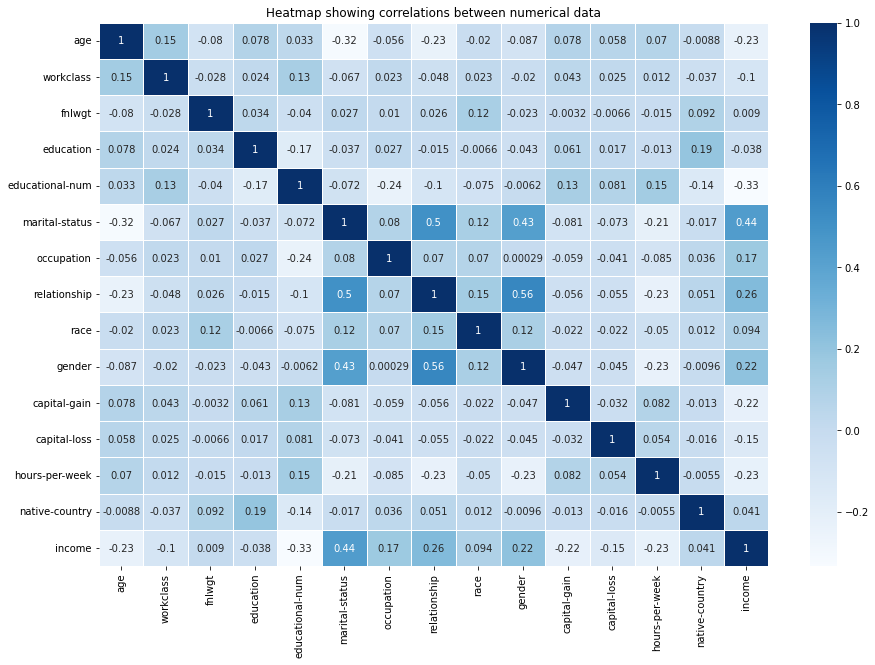

In [136]:
plt.figure(figsize=(15,10))  
sns.heatmap(df.corr(),annot=True,linewidths=.5, cmap="Blues")
plt.title('Heatmap showing correlations between numerical data')
plt.show()

In [137]:
fair_metrics(df, df['income'], 'income', ['gender'])

{'disparate_impact_gender': 0.35753759606703406,
 'statistical_parity_difference_gender': -0.19615422907428784,
 'equal_opportunity_difference_gender': 0.0}

In [138]:
def distribution_features_groups(df, sensitive_attribute):
    fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 7), sharex=False, sharey=False)
    axes = axes.ravel()  # array to 1D
    columns = df.columns
    cols = columns[columns != sensitive_attribute]  # create a list of dataframe columns to use

    for col, ax in zip(cols, axes):
        data = df[[col, sensitive_attribute]]  # select the data
        sns.kdeplot(data=data, x=col, hue=sensitive_attribute, shade=True, ax=ax)
        ax.set(title=f'Distribution of Column: {col}', xlabel=None)
        
    fig.delaxes(axes[-1]) # delete the empty subplot
    fig.tight_layout()
    return plt.show()

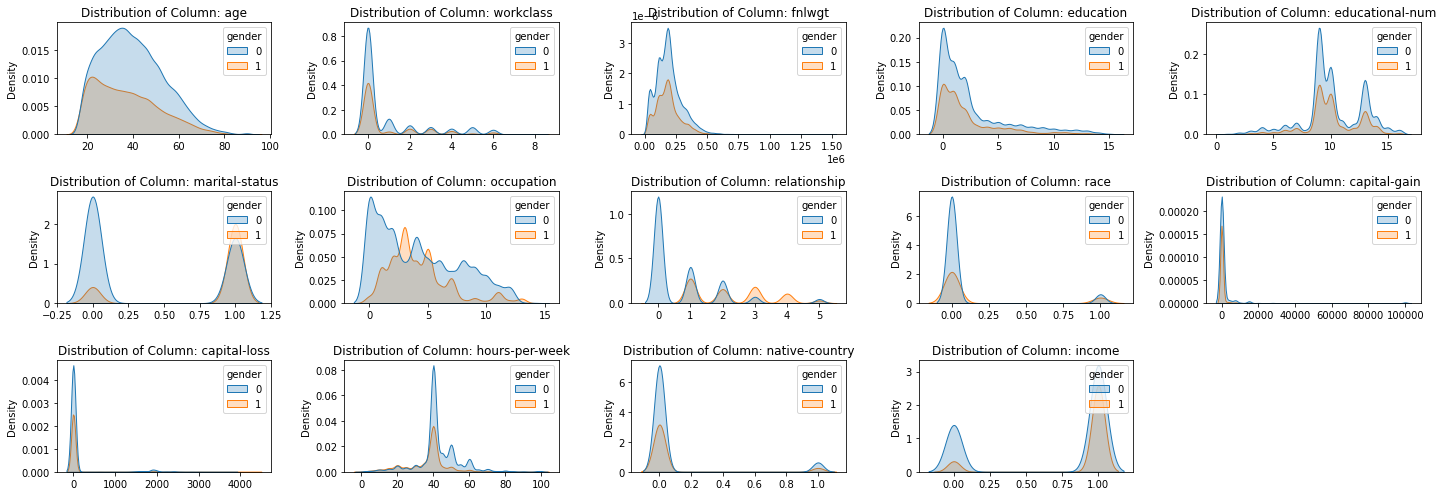

In [139]:
distribution_features_groups(df, 'gender')

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


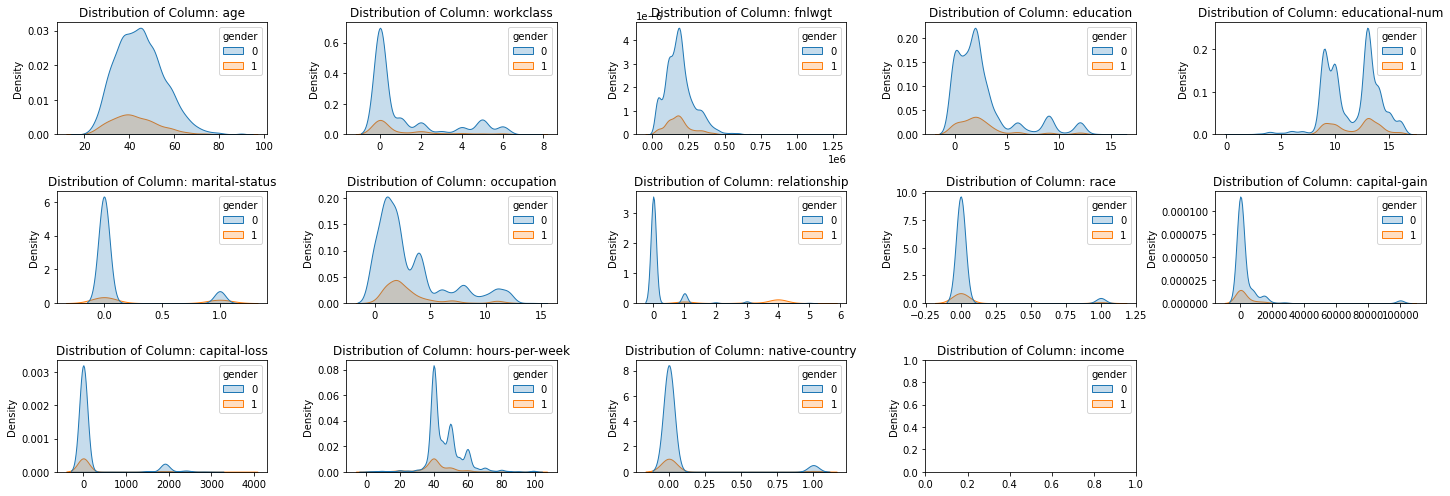

In [140]:
distribution_features_groups(df[df['income'] == 0], 'gender')

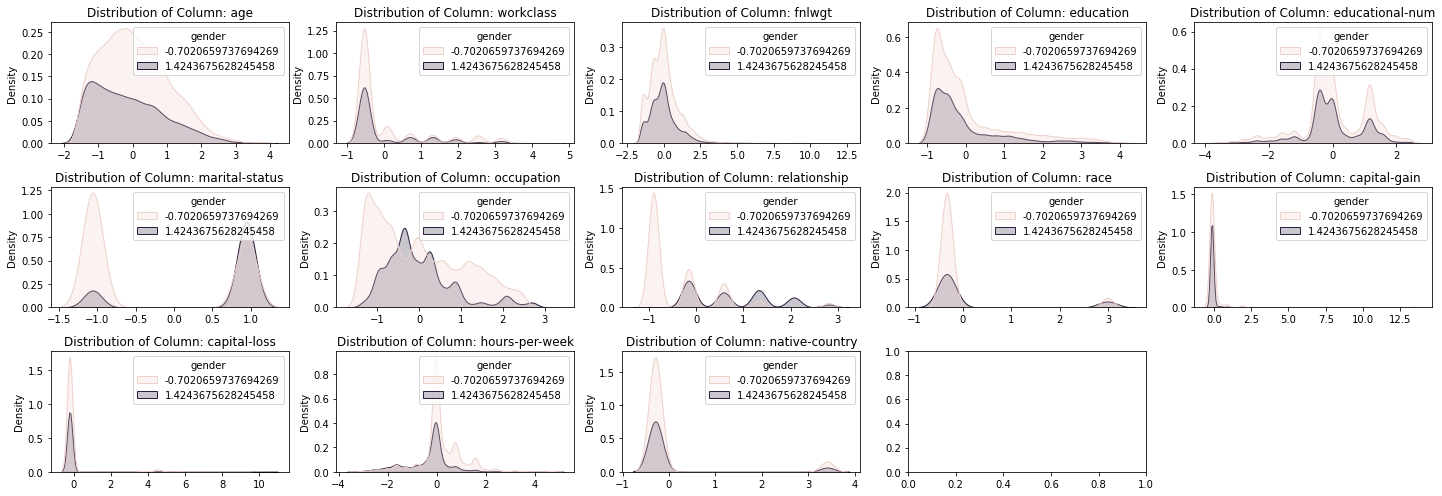

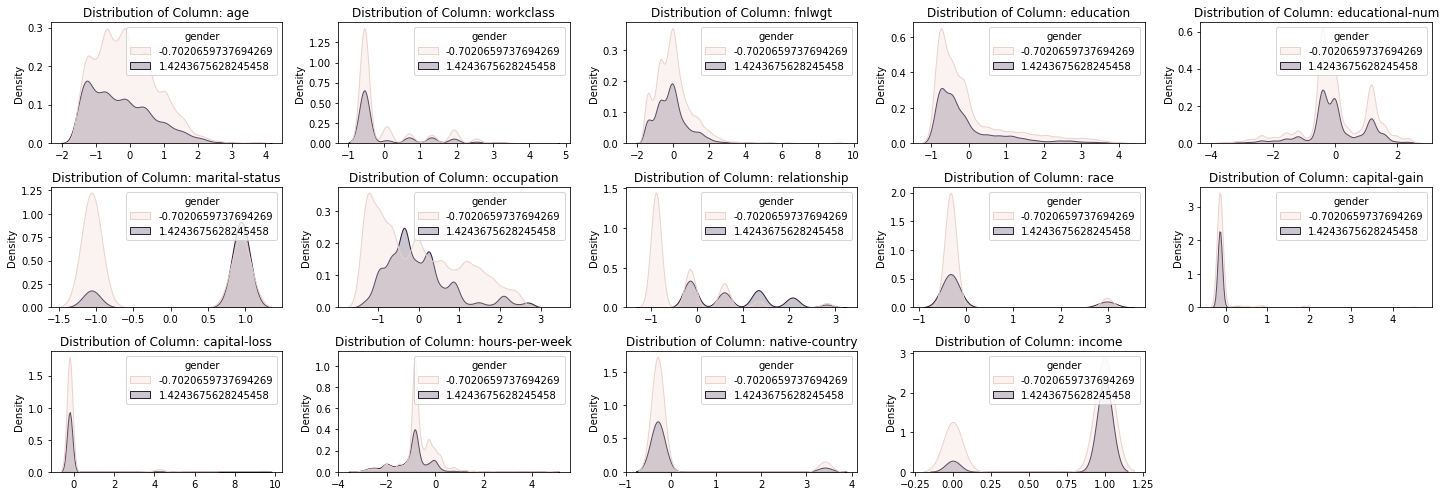

In [141]:
distribution_features_groups(x_train, 'gender')
distribution_features_groups(df_trans, 'gender')

## Beta coeff experiment 

In [142]:
#Function to transform the continuous prediciton to a binary classification 

def binomial_classification(y_predition):
    
    '''Transform the continual prediction to a binary classification
        1 = Default, 0 = Non Default 
        input = the continuos prediction from the model
        output = pandas data frame with the binary classification on the colum prediction '''

    y_predict = pd.DataFrame(y_predition, columns=['prediction'])
    y_predict['prediction'][y_predict['prediction'] >= 0.5] = 1
    y_predict['prediction'][y_predict['prediction'] < 0.5] = 0
    return y_predict

In [143]:
linear_model = sm.OLS(y_train.reset_index(drop=True), x_train).fit()
linear_model_trans = sm.OLS(y_trans, x_trans_test).fit()

In [144]:
# Calculatet the weight
df_train_rw = df_train.copy()
df_train_rw['gender'][df_train_rw['gender'] < 0] = 0
df_train_rw['gender'][df_train_rw['gender'] > 0] = 1

weights = reweighing(df_train_rw, 'income', 'gender')
linear_models_reweigh = sm.WLS(y_train.reset_index(drop=True), x_train, weights=weights).fit()

In [145]:
#Buils a data frame for comparison
comparison_df = pd.DataFrame(data = {
    'Non-processed': linear_model.params,
    'DIR df': linear_model_trans.params
})

#Calculate the change in beta coeff and metrics
comparison_df['change %'] = ((comparison_df['DIR df'] - comparison_df['Non-processed']) / comparison_df['Non-processed']) * 100
comparison_df

,Non-processed,DIR df,change %
age,-0.0422,-0.1099,160.5020
workclass,-0.0092,-0.0245,165.5413
fnlwgt,-0.0159,-0.0345,117.3883
education,-0.0257,-0.0194,-24.7267
educational-num,-0.1101,-0.0586,-46.7875
marital-status,0.1450,0.0902,-37.8016
occupation,0.0261,0.0102,-60.7164
relationship,-0.0167,-0.0543,225.7339
race,0.0103,0.1399,1262.0536
gender,0.0177,-0.0268,-251.3229


In [146]:
#Buils a data frame for comparison
comparison_df = pd.DataFrame(data = {
    'Non-processed': linear_model.params,
    'reweighted df': linear_models_reweigh.params
})

#Calculate the change in beta coeff and metrics
comparison_df['change %'] = ((comparison_df['reweighted df'] - comparison_df['Non-processed']) / comparison_df['Non-processed']) * 100
comparison_df

,Non-processed,reweighted df,change %
age,-0.0422,-0.0437,3.4964
workclass,-0.0092,-0.0111,21.0887
fnlwgt,-0.0159,-0.0159,0.4178
education,-0.0257,-0.0265,2.9562
educational-num,-0.1101,-0.1140,3.5730
marital-status,0.1450,0.1269,-12.4782
occupation,0.0261,0.0270,3.3187
relationship,-0.0167,0.0154,-192.1219
race,0.0103,0.0073,-29.0514
gender,0.0177,-0.0556,-414.7345


In [147]:
# Prediction on the test dataset and trasformation to a bionomial classification 1 = income, 0 = non income
y_predict = binomial_classification(linear_model.predict(x_test))
y_predict_trans = binomial_classification(linear_model_trans.predict(x_test))

#Claculate the disparate impact metric for preprocessed and non-processed experiment
metric_df = pd.DataFrame(x_test, columns = x.columns).copy()
metric_df['gender'][metric_df['gender'] < 0] = 0
metric_df['gender'][metric_df['gender'] > 0] = 1
metric_df.insert(0, 'income', y_test.reset_index(drop=True))

lr_metric = fair_metrics(metric_df, y_predict.values.ravel(), 'income', ['gender'])
lr_trans_metric = fair_metrics(metric_df, y_predict_trans.values.ravel(), 'income', ['gender'])
metrics_comparison = pd.DataFrame([lr_metric,lr_trans_metric], index=['linear model','linear model trans']).T
metrics_comparison['change %'] = ((metrics_comparison['linear model trans'] - metrics_comparison['linear model']) / metrics_comparison['linear model']) * 100

In [148]:
metrics_comparison

,linear model,linear model trans,change %
disparate_impact_gender,0.9982,0.8353,-16.3234
statistical_parity_difference_gender,-0.0018,-0.1440,7896.1929
equal_opportunity_difference_gender,0.0000,-0.0386,-inf


In [149]:
y_predict_reweight = binomial_classification(linear_models_reweigh.predict(x_test))
lr_reweight_metric = fair_metrics(metric_df, y_predict_reweight.values.ravel(), 'income', ['gender'])
metrics_comparison = pd.DataFrame([lr_metric,lr_reweight_metric], index=['linear model','linear model reweight']).T
metrics_comparison['change %'] = ((metrics_comparison['linear model reweight'] - metrics_comparison['linear model']) / metrics_comparison['linear model']) * 100

In [150]:
metrics_comparison

,linear model,linear model reweight,change %
disparate_impact_gender,0.9982,1.0062,0.8054
statistical_parity_difference_gender,-0.0018,0.0062,-444.1216
equal_opportunity_difference_gender,0.0000,0.0003,inf


In [151]:
print(linear_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                 income   R-squared (uncentered):                   0.082
Model:                            OLS   Adj. R-squared (uncentered):              0.081
Method:                 Least Squares   F-statistic:                              176.7
Date:                Fri, 15 Jul 2022   Prob (F-statistic):                        0.00
Time:                        14:46:28   Log-Likelihood:                         -34564.
No. Observations:               27868   AIC:                                  6.916e+04
Df Residuals:                   27854   BIC:                                  6.927e+04
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

In [152]:
print(linear_model_trans.summary())

                                 OLS Regression Results                                
Dep. Variable:                 income   R-squared (uncentered):                   0.526
Model:                            OLS   Adj. R-squared (uncentered):              0.526
Method:                 Least Squares   F-statistic:                              2211.
Date:                Fri, 15 Jul 2022   Prob (F-statistic):                        0.00
Time:                        14:46:28   Log-Likelihood:                         -25337.
No. Observations:               27868   AIC:                                  5.070e+04
Df Residuals:                   27854   BIC:                                  5.082e+04
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

In [153]:
print(linear_models_reweigh.summary())

                                 WLS Regression Results                                
Dep. Variable:                 income   R-squared (uncentered):                   0.075
Model:                            WLS   Adj. R-squared (uncentered):              0.074
Method:                 Least Squares   F-statistic:                              160.6
Date:                Fri, 15 Jul 2022   Prob (F-statistic):                        0.00
Time:                        14:46:28   Log-Likelihood:                         -35027.
No. Observations:               27868   AIC:                                  7.008e+04
Df Residuals:                   27854   BIC:                                  7.020e+04
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

#### Interactional effect

In [154]:
import statsmodels.formula.api as smf
formula = 'income ~ gender*age*race + workclass + fnlwgt + education + occupation + relationship'
model = smf.ols(formula, data=df_train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     381.4
Date:                Fri, 15 Jul 2022   Prob (F-statistic):               0.00
Time:                        14:46:28   Log-Likelihood:                -13647.
No. Observations:               27868   AIC:                         2.732e+04
Df Residuals:                   27855   BIC:                         2.743e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.7645      0.002    3

In [155]:
formula = 'income ~ gender*age*race + workclass + fnlwgt + education + occupation + relationship'
model = smf.ols(formula, data=df_trans)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     377.6
Date:                Fri, 15 Jul 2022   Prob (F-statistic):               0.00
Time:                        14:46:28   Log-Likelihood:                -13667.
No. Observations:               27868   AIC:                         2.736e+04
Df Residuals:                   27855   BIC:                         2.747e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.7496      0.002    3

## Random Forrest experiment

In [156]:
# Model trained with original df
rf = RandomForestClassifier().fit(x_train, y_train)
y_preds_rf = rf.predict(x_test)
print(classification_report(y_test, y_preds_rf))

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


              precision    recall  f1-score   support

           0       0.74      0.62      0.68      4531
           1       0.88      0.93      0.91     14048

    accuracy                           0.85     18579
   macro avg       0.81      0.78      0.79     18579
weighted avg       0.85      0.85      0.85     18579



In [157]:
# Model trained with DIR df
rf_trans = RandomForestClassifier().fit(x_trans_test, y_trans)
y_preds_rf_trans = rf_trans.predict(x_test)
print(classification_report(y_test, y_preds_rf_trans))

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


              precision    recall  f1-score   support

           0       0.71      0.63      0.67      4531
           1       0.89      0.92      0.90     14048

    accuracy                           0.85     18579
   macro avg       0.80      0.77      0.79     18579
weighted avg       0.84      0.85      0.84     18579



In [158]:
# Model trained with reweigh df
rf_reweight = RandomForestClassifier().fit(x_train, y_train, sample_weight= weights)
y_preds_rf_reweight = rf_reweight.predict(x_test)
print(classification_report(y_test, y_preds_rf_reweight))

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


              precision    recall  f1-score   support

           0       0.74      0.63      0.68      4531
           1       0.89      0.93      0.91     14048

    accuracy                           0.86     18579
   macro avg       0.81      0.78      0.79     18579
weighted avg       0.85      0.86      0.85     18579



In [159]:
#Claculate the disparate impact metric for preprocessed and non-processed experiment
metric_df = pd.DataFrame(x_test, columns = x.columns).copy()
metric_df['gender'][metric_df['gender'] < 0] = 0
metric_df['gender'][metric_df['gender'] > 0] = 1
metric_df.insert(0, 'income', y_test.reset_index(drop=True))

rf_metric = fair_metrics(metric_df, pd.DataFrame(y_preds_rf).values.ravel(), 'income', ['gender'])
rf_trans_metric = fair_metrics(metric_df, y_preds_rf_trans, 'income', ['gender'])
metrics_comparison_rf_DIR = pd.DataFrame([rf_metric,rf_trans_metric], index=['rf','rf DIR']).T
metrics_comparison_rf_DIR['change %'] = ((metrics_comparison_rf_DIR['rf DIR'] - metrics_comparison_rf_DIR['rf']) / metrics_comparison_rf_DIR['rf']) * 100

In [160]:
metrics_comparison_rf_DIR

,rf,rf DIR,change %
disparate_impact_gender,0.3248,0.2964,-8.7527
statistical_parity_difference_gender,-0.1783,-0.1990,11.6116
equal_opportunity_difference_gender,-0.0603,-0.1060,75.8545


In [161]:
rf_reweight_metric = fair_metrics(metric_df, y_preds_rf_reweight, 'income', ['gender'])
metrics_comparison_rf_reweight = pd.DataFrame([rf_metric,rf_reweight_metric], index=['rf','rf reweight']).T
metrics_comparison_rf_reweight['change %'] = ((metrics_comparison_rf_reweight['rf reweight'] - metrics_comparison_rf_reweight['rf']) / metrics_comparison_rf_reweight['rf']) * 100

In [162]:
metrics_comparison_rf_reweight

,rf,rf reweight,change %
disparate_impact_gender,0.3248,0.3082,-5.1153
statistical_parity_difference_gender,-0.1783,-0.1860,4.3036
equal_opportunity_difference_gender,-0.0603,-0.1008,67.2143


### Logistic regression 

In [165]:
from sklearn.linear_model import LogisticRegression

log = LogisticRegression().fit(x_train, y_train)
y_preds_log = log.predict(x_test)
print(classification_report(y_test, y_preds_rf))


log_reweight = LogisticRegression().fit(x_train, y_train, sample_weight= weights)
y_preds_log_reweight = log_reweight.predict(x_test)
print(classification_report(y_test, y_preds_log_reweight))

              precision    recall  f1-score   support

           0       0.74      0.62      0.68      4531
           1       0.88      0.93      0.91     14048

    accuracy                           0.85     18579
   macro avg       0.81      0.78      0.79     18579
weighted avg       0.85      0.85      0.85     18579

              precision    recall  f1-score   support

           0       0.73      0.53      0.61      4531
           1       0.86      0.94      0.90     14048

    accuracy                           0.84     18579
   macro avg       0.79      0.73      0.76     18579
weighted avg       0.83      0.84      0.83     18579



X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


In [168]:
log_metric = fair_metrics(metric_df, pd.DataFrame(y_preds_log).values.ravel(), 'income', ['gender'])
log_reweigh_metric = fair_metrics(metric_df, y_preds_log_reweight, 'income', ['gender'])
metrics_comparison_log_DIR = pd.DataFrame([log_metric,log_reweigh_metric], index=['log','log reweight']).T
metrics_comparison_log_DIR['change %'] = ((metrics_comparison_log_DIR['log reweight'] - metrics_comparison_log_DIR['log']) / metrics_comparison_log_DIR['log']) * 100

In [169]:
metrics_comparison_log_DIR

,log,log reweight,change %
disparate_impact_gender,0.2346,0.5513,135.0125
statistical_parity_difference_gender,-0.1919,-0.0938,-51.1441
equal_opportunity_difference_gender,-0.1626,0.0950,-158.4028
